## Importing Modules

In [189]:
from dataclasses import dataclass, asdict
from dataclass_csv import DataclassReader
from typing import Optional
from enum import Enum
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Reading the Data

In [149]:
class InfillPattern(Enum):
    GRID = "grid"
    HONEYCOMB = "honeycomb"

In [150]:
class Material(Enum):
    ABS = "abs"
    PLA = "pla"

In [151]:
@dataclass
class ThreeDPrinterData:
    layer_height: float
    wall_thickness: int
    infill_density: int
    infill_pattern: InfillPattern
    nozzle_temperature: int
    bed_temperature: int
    print_speed: int
    material: Material
    fan_speed: int
    roughness: int
    tensile_strength: int
    elongation: float

In [152]:
FILENAME = './3dprinterdata_edited.csv'

In [180]:
def readCSVData(flname):
    with open(flname) as data_csv:
        reader = DataclassReader(data_csv, ThreeDPrinterData)
        reader.map('Tensile Strength').to('tensile_strength')
        reader.map('Elongation').to('elongation')
        data_objects = []
        for row in reader:
            data_objects.append(row)
    
    df = pd.DataFrame(data_objects)
    df['infill_pattern'] = df['infill_pattern'].map(lambda obj: obj.value)
    df['material'] = df['material'].map(lambda obj: obj.value)
    
    return df

In [181]:
df = readCSVData(FILENAME)

## Exploratory Data Analysis

In [326]:
class GeneralStatistics:
    def __init__(self, data):
        self.data = data
        self.cor = self.data.corr()
        
    def counts(self):
        print("There are {} datapoints and {} features".format(self.data.shape[0], self.data.shape[1]))
        
    def isNull(self):
        total = sum(self.data.isnull().sum())
        print("There are {} null values in the dataset".format(total))
        
    def descriptiveStats(self):
        print("\nThis is the mean value of all the variables\n\n")
        return self.data.describe().T['mean']
    
    def pairwiseCorrelation(self):
        plt.figure(figsize = (12, 12))
        sns.heatmap(self.cor, cbar = True, annot = True, cmap = 'Blues')
        
    def correlatedFeatures(self, target, positive = 0.4, negative = -0.1):
        cor_target = self.cor[target]
        
        positive_cor_features = cor_target[cor_target >= positive]
        pos_corr = [(feature, value) for feature, value in zip(positive_cor_features.index, positive_cor_features.values) if feature not in target]
        
        negative_cor_features = cor_target[cor_target <= negative]
        neg_corr = [(feature, value) for feature, value in zip(negative_cor_features.index, negative_cor_features.values) if feature not in target]
        
        return {'target': target, 
                'postive_cor': pos_corr, 
                'negative_cor': neg_corr}
    
    def targetRelation(self, corr_stats):
        features = []
        out = {}
        for k, v in corr_stats.items():
            if k == 'target':
                target_var = v
            else:
                for (feature, score) in v:
                    features.append(feature)
        out = {'target': target_var, 'features': features}
        
        for feature in features:
            self.scatterPlot(feature, out['target'], self.data)
    
    def scatterPlot(self, x, y, data):
        sns.lmplot(x = x, y = y, data = data)

In [327]:
statsObj = GeneralStatistics(df)

In [328]:
statsObj.counts()
statsObj.isNull()
statsObj.descriptiveStats()

There are 46 datapoints and 12 features
There are 0 null values in the dataset

This is the mean value of all the variables




layer_height            0.108696
wall_thickness          5.065217
infill_density         54.565217
nozzle_temperature    222.173913
bed_temperature        70.108696
print_speed            65.652174
fan_speed              50.543478
roughness             174.021739
tensile_strength       20.065217
elongation              1.665217
Name: mean, dtype: float64

### Target = 'roughness'

In [329]:
roughness_corr = statsObj.correlatedFeatures(target = 'roughness')
roughness_corr

{'target': 'roughness',
 'postive_cor': [('layer_height', 0.773679521409528),
  ('nozzle_temperature', 0.40997688511573716)],
 'negative_cor': [('wall_thickness', -0.19931620751820497)]}

{'target': 'roughness',
 'features': ['layer_height', 'nozzle_temperature', 'wall_thickness']}

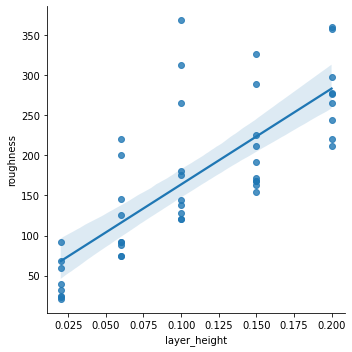

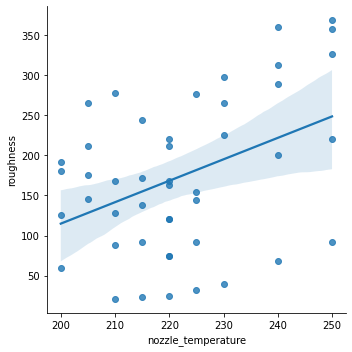

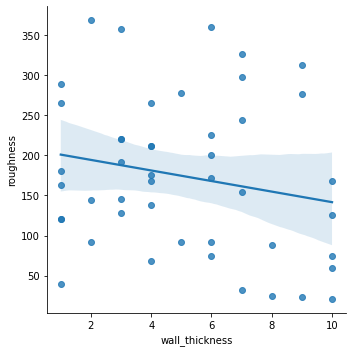

In [330]:
statsObj.targetRelation(roughness_corr)

### Target = 'tensile_strength'

In [331]:
tensile_corr = statsObj.correlatedFeatures(target = 'tensile_strength')
tensile_corr

{'target': 'tensile_strength',
 'postive_cor': [('wall_thickness', 0.4299783187945704),
  ('elongation', 0.8374528823899959)],
 'negative_cor': [('nozzle_temperature', -0.41892249542050286),
  ('bed_temperature', -0.27459601199575845),
  ('print_speed', -0.26858492509302073),
  ('fan_speed', -0.2745960119957587)]}

{'target': 'tensile_strength',
 'features': ['wall_thickness',
  'elongation',
  'nozzle_temperature',
  'bed_temperature',
  'print_speed',
  'fan_speed']}

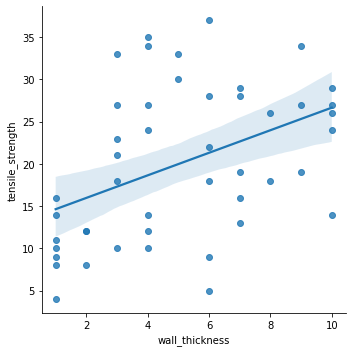

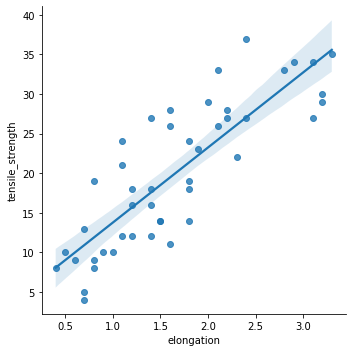

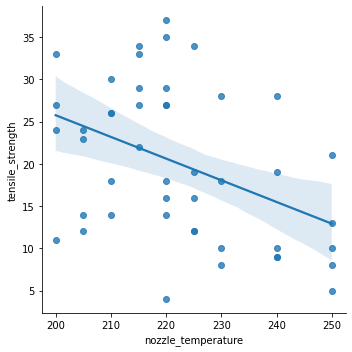

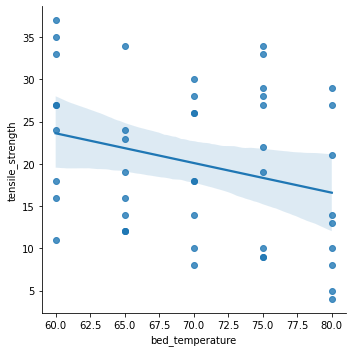

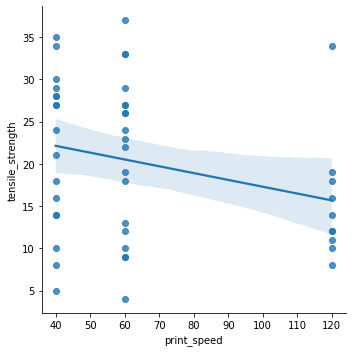

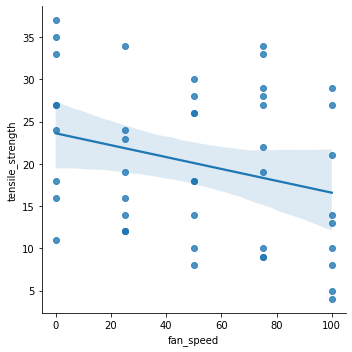

In [332]:
statsObj.targetRelation(tensile_corr)

### Target = 'elongation'

In [333]:
elongation_corr = statsObj.correlatedFeatures(target = 'elongation')
elongation_corr

{'target': 'elongation',
 'postive_cor': [('layer_height', 0.49325265653442163),
  ('tensile_strength', 0.8374528823899959)],
 'negative_cor': [('nozzle_temperature', -0.5254619483514119),
  ('bed_temperature', -0.29082737182897916),
  ('print_speed', -0.23063858127718095),
  ('fan_speed', -0.29082737182897994)]}

In [ ]:
statsObj.targetRelation(elongation_corr)

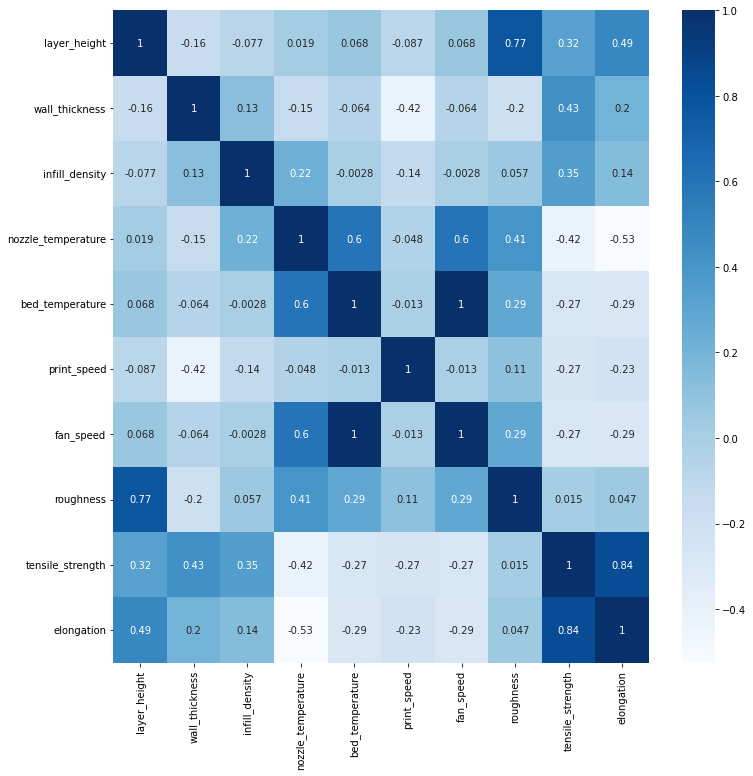

In [300]:
statsObj.pairwiseCorrelation()

### Some general insights -
A good start is to look at some descriptive statistics -

1. There are in total 46 datapoints
2. There are two categorical variables which need to be one-hot encoded
3. The mean of each term shows that the data needs to be normalized before the model is trained.
4. With response variable : 
    * 'roughness' : 'layer_height'(0.77) and 'nozzle_temperature'(0.41) are **positively** correlated AND 'wall_thickness' (-0.20) is **negatively** correlated
    * 'tensile_strength' : 'wall_thickness'(0.43) and 'elongation'(0.84) are **positively** correlated 'nozzle_temperature'(-0.42), 'bed_temperature'(-0.27), 'print_speed'(-0.27), 'fan_speed'(-0.27) are **negatively** correlated
    * 'elongation': 'layer_height'(0.49) and 'tensile_strength'(0.84) are **positively** correlated and 'nozzle_temperature'(-0.52), 'bed_temperature'(-0.29), 'print_speed'(-0.23) and 'fan_speed'(-0.29) are **negatively** correlated